# train/test/validation LAD vs. skl

## Init

In [1]:
from sklearn import linear_model

from f_data_prep import *
from f_drosophila_infer import *
from f_train import *

In [2]:
data_all = np.loadtxt('../data_complete.txt')
all_bin = np.vsplit(data_all, 6)
all_init = np.vstack([all_bin[i] for i in range(5)])
all_diff = np.vstack([all_bin[i+1]-all_bin[i] for i in range(5)])

complete_all = ([int(x) - 1 for x in open('../indices_complete.txt','r').readline().split()])
comp_ind = list(map(int, list((np.array(complete_all)[::6]-3)/6)))

data_comp = np.copy(data_all[:, comp_ind])
comp_bin = np.vsplit(data_comp, 6)
comp_diff = np.vstack([comp_bin[i+1] - comp_bin[i] for i in range(5)])

### Load validation cells

In [3]:
with open('./pickles/validation_cells.pkl', 'rb') as f:
    cells_v = pickle.load(f)

## Def

In [4]:
def LAD_cv_quad_cellselect(X, y, gene_comp=comp_ind, kf=10):
    kfold = KFold(n_splits=kf, shuffle=False)
    
    if len(gene_comp) > 0:
        X_in = np.copy(X[:, comp_ind])
    else:
        X_in = np.copy(X)
    
    quad = np.copy(X_in)
    
    w_list = []
    bias_list = []
    
    val = np.hstack([cells_v+(6078*i) for i in range(5)])
    cells_tt = np.delete(range(6078), cells_v)
    tr_te = np.hstack([cells_tt+(6078*i) for i in range(5)])
    
    if len(gene_comp) > 0:
        for i in range(X_in.shape[1]-1):
            for j in range(i+1, X_in.shape[1]):
                quad = np.hstack((quad, (X_in[:,i]*X_in[:,j])[:,None]))
    else:
        for i in range(len(comp_ind)-1):
            for j in range(i+1, len(comp_ind)):
                quad = np.hstack((quad, (X_in[:,comp_ind[i]]*X_in[:,comp_ind[j]])[:,None]))
    
    quad_v = quad[val]
    y_v = y[val]
    quad_tt = quad[tr_te]
    y_tt = y[tr_te]
    
    for (cell_tr, cell_te) in (kfold.split(range(5470))):
        te = np.hstack([cell_te+(5470*i) for i in range(5)])
        tr = np.hstack([cell_tr+(5470*i) for i in range(5)])
        quad_tr, y_tr = quad_tt[tr], y_tt[tr]
        quad_te, y_te = quad_tt[te], y_tt[te]
        
        w,bias = infer_LAD_v(quad_tr, y_tr, quad_te, y_te)
        w_list.append(w)
        bias_list.append(bias)
        
    w = np.mean(w_list, axis=0)
    bias = np.mean(bias_list, axis=0)
    
    print(w.shape, bias.shape)
    
    if y.shape[1] == 27:
        X_init = np.copy(X[:, comp_ind][val])
    else:
        X_init = np.copy(X[val])
    
    yp = X_init + bias + quad_v.dot(w)
    yp[yp<0] = 0
    ya = X_init + y_v
    ferror = np.sum(np.abs(yp - ya), axis=0)/np.sum(np.abs(ya), axis=0)
    error1 = np.abs(yp - ya)
    
    dic = {
        'ferror': ferror,
        'error': error1,
        'w': w,
        'bias': bias
    }
    return dic

def infer_all_LAD(X_all, y_all, y_comp):
    res=[]
    results = LAD_cv_quad_cellselect(X_all, y_all, gene_comp=[], kf=10)
    res.append(results)
    results = LAD_cv_quad_cellselect(X_all, y_comp, gene_comp=[], kf=10)
    res.append(results)
    results = LAD_cv_quad_cellselect(X_all, y_comp, gene_comp=comp_ind, kf=10)
    res.append(results)
    results = LAD_cv_quad_cellselect(X_all, y_all, gene_comp=comp_ind, kf=10)
    res.append(results)
    return res

def skl_cv_quad_cellselect(X, y, gene_comp=comp_ind, kf=10):
    kfold = KFold(n_splits=kf, shuffle=False)
    
    if len(gene_comp) > 0:
        X_in = np.copy(X[:, comp_ind])
    else:
        X_in = np.copy(X)
    
    quad = np.copy(X_in)
    
    w_list = []
    bias_list = []
    
    val = np.hstack([cells_v+(6078*i) for i in range(5)])
    cells_tt = np.delete(range(6078), cells_v)
    tr_te = np.hstack([cells_tt+(6078*i) for i in range(5)])
    
    if len(gene_comp) > 0:
        for i in range(X_in.shape[1]-1):
            for j in range(i+1, X_in.shape[1]):
                quad = np.hstack((quad, (X_in[:,i]*X_in[:,j])[:,None]))
    else:
        for i in range(len(comp_ind)-1):
            for j in range(i+1, len(comp_ind)):
                quad = np.hstack((quad, (X_in[:,comp_ind[i]]*X_in[:,comp_ind[j]])[:,None]))
    
    quad_v = quad[val]
    y_v = y[val]
    quad_tt = quad[tr_te]
    y_tt = y[tr_te]
    
    for (cell_tr, cell_te) in (kfold.split(range(5470))):
        te = np.hstack([cell_te+(5470*i) for i in range(5)])
        tr = np.hstack([cell_tr+(5470*i) for i in range(5)])
        quad_tr, y_tr = quad_tt[tr], y_tt[tr]
        quad_te, y_te = quad_tt[te], y_tt[te]
        
        regr=linear_model.LinearRegression()
        regr.fit(quad_tr, y_tr)
        w_list.append(regr.coef_)
        bias_list.append(regr.intercept_)
        
    w = np.mean(w_list, axis=0).T
    bias = np.mean(bias_list, axis=0)
    
    print(w.shape, bias.shape)
    
    if y.shape[1] == 27:
        X_init = np.copy(X[:, comp_ind][val])
    else:
        X_init = np.copy(X[val])
    
    yp = X_init + bias + quad_v.dot(w)
    yp[yp<0] = 0
    ya = X_init + y_v
    ferror = (np.sum(np.abs(yp - ya)**2, axis=0)/np.sum(np.abs(ya)**2, axis=0))**(1/2)
    error1 = np.abs(yp - ya)
    
    dic = {
        'ferror': ferror,
        'error': error1,
        'w': w,
        'bias': bias
    }
    return dic

def infer_all_skl(X_all, y_all, y_comp):
    res=[]
    results = skl_cv_quad_cellselect(X_all, y_all, gene_comp=[], kf=10)
    res.append(results)
    results = skl_cv_quad_cellselect(X_all, y_comp, gene_comp=[], kf=10)
    res.append(results)
    results = skl_cv_quad_cellselect(X_all, y_comp, gene_comp=comp_ind, kf=10)
    res.append(results)
    results = skl_cv_quad_cellselect(X_all, y_all, gene_comp=comp_ind, kf=10)
    res.append(results)
    return res



## Run & Save

In [5]:
LAD_quad_cellselect = infer_all_LAD(all_init, all_diff, comp_diff)
skl_quad_cellselect = infer_all_skl(all_init, all_diff, comp_diff)

with open('./pickles/LAD_quad_ttv.pkl', 'wb') as f:
    pickle.dump(LAD_quad_cellselect, f)

with open('./pickles/skl_quad_ttv.pkl', 'wb') as f:
    pickle.dump(skl_quad_cellselect, f)

(450, 99) (1, 99)
(450, 27) (1, 27)
(378, 27) (1, 27)
(378, 99) (1, 99)
(450, 99) (99,)
(450, 27) (27,)
(378, 27) (27,)
(378, 99) (99,)


In [6]:
with open('./pickles/LAD_quad_ttv.pkl', 'rb') as f:
    LAD_quad_v = pickle.load(f)

with open('./pickles/skl_quad_ttv.pkl', 'rb') as f:
    skl_quad_v = pickle.load(f)

## Results: LAD vs. skl

### (99,27) to 99

MannwhitneyuResult(statistic=4335688.0, pvalue=1.5483242351660361e-05)
MannwhitneyuResult(statistic=4571420.0, pvalue=0.23528059047295241)


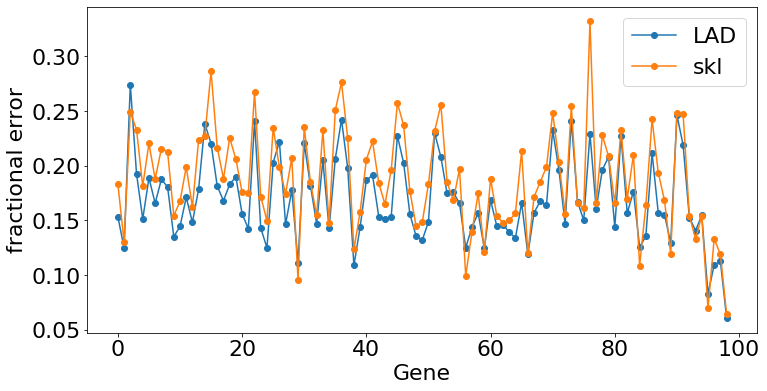

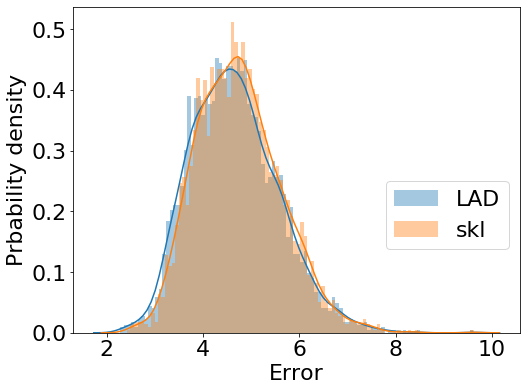

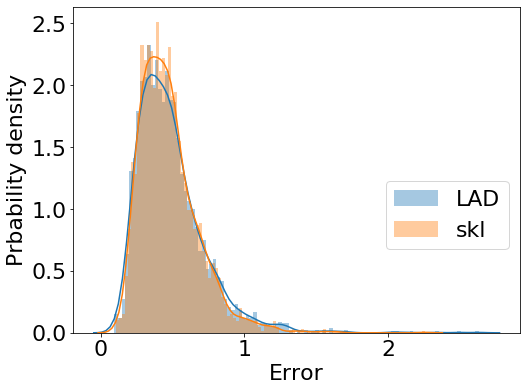

In [7]:
%matplotlib inline
import seaborn as sns

matplotlib.rcParams.update({'font.size':22})

plt.figure(figsize=(12,6))
plt.plot(range(len(LAD_quad_v[0]['ferror'])), LAD_quad_v[0]['ferror'], 'o-', label='LAD')
plt.plot(range(len(skl_quad_v[0]['ferror'])), skl_quad_v[0]['ferror'], 'o-', label='skl')
plt.legend(loc='best')
plt.xlabel('Gene')
plt.ylabel('fractional error')

plt.figure(figsize=(8,6))
error_lad = np.sum(LAD_quad_v[0]['error'], axis=1)
sns.distplot(error_lad, bins=100, label='LAD')
error_skl = np.sum(skl_quad_v[0]['error'], axis=1)
sns.distplot(error_skl, bins=100, label='skl')
plt.legend(bbox_to_anchor=(1,0.5))
plt.xlabel('Error')
plt.ylabel('Prbability density')

print(stats.mannwhitneyu(error_lad, error_skl))

plt.figure(figsize=(8,6))
error_lad = np.sum(LAD_quad_v[0]['error']**2, axis=1)
sns.distplot(error_lad, bins=100, label='LAD')
error_skl = np.sum(skl_quad_v[0]['error']**2, axis=1)
sns.distplot(error_skl, bins=100, label='skl')
plt.legend(bbox_to_anchor=(1,0.5))
plt.xlabel('Error')
plt.ylabel('Prbability density')

print(stats.mannwhitneyu(error_lad, error_skl))
    
    

### (99,27) to 27

In [8]:
# plt.figure(figsize=(12,6))
# plt.plot(range(len(LAD_quad_v[1]['ferror'])), LAD_quad_v[1]['ferror'], 'o-', label='LAD')
# plt.plot(range(len(skl_quad_v[1]['ferror'])), skl_quad_v[1]['ferror'], 'o-', label='skl')
# plt.legend(loc='best')
# plt.xlabel('Gene')
# plt.ylabel('Fractional error')

# plt.figure(figsize=(8,6))
# error_lad = np.sum(LAD_quad_v[1]['error'], axis=1)
# sns.distplot(error_lad, bins=100, label='LAD')
# error_skl = np.sum(skl_quad_v[1]['error'], axis=1)
# sns.distplot(error_skl, bins=100, label='skl')
# plt.legend(bbox_to_anchor=(1,0.5))
# plt.xlabel('Error')
# plt.ylabel('Prbability density')

# print(stats.mannwhitneyu(error_lad, error_skl))

# plt.figure(figsize=(8,6))
# error_lad = np.sum(LAD_quad_v[1]['error']**2, axis=1)
# sns.distplot(error_lad, bins=100, label='LAD')
# error_skl = np.sum(skl_quad_v[1]['error']**2, axis=1)
# sns.distplot(error_skl, bins=100, label='skl')
# plt.legend(bbox_to_anchor=(1,0.5))
# plt.xlabel('Error')
# plt.ylabel('Prbability density')

# print(stats.mannwhitneyu(error_lad, error_skl))

### (27,27) to 27

In [9]:
# plt.figure(figsize=(12,6))
# plt.plot(range(len(LAD_quad_v[2]['ferror'])), LAD_quad_v[2]['ferror'], 'o-', label='LAD')
# plt.plot(range(len(skl_quad_v[2]['ferror'])), skl_quad_v[2]['ferror'], 'o-', label='skl')
# plt.xlabel('Gene')
# plt.ylabel('Fractional error')
# plt.legend(loc='best')

# plt.figure(figsize=(8,6))
# error_lad = np.sum(LAD_quad_v[2]['error'], axis=1)
# sns.distplot(error_lad, bins=100, label='LAD')
# error_skl = np.sum(skl_quad_v[2]['error'], axis=1)
# sns.distplot(error_skl, bins=100, label='skl')
# plt.legend(bbox_to_anchor=(1,0.5))
# plt.xlabel('Error')
# plt.ylabel('Prbability density')

# print(stats.mannwhitneyu(error_lad, error_skl))

# plt.figure(figsize=(8,6))
# error_lad = np.sum(LAD_quad_v[2]['error']**2, axis=1)
# sns.distplot(error_lad, bins=100, label='LAD')
# error_skl = np.sum(skl_quad_v[2]['error']**2, axis=1)
# sns.distplot(error_skl, bins=100, label='skl')
# plt.legend(bbox_to_anchor=(1,0.5))
# plt.xlabel('Error')
# plt.ylabel('Prbability density')

# print(stats.mannwhitneyu(error_lad, error_skl))

# train/validation skl

## Def

In [10]:
def skl_cv_quad_cellselect(X, y, gene_comp=comp_ind, kf=10):
    kfold = KFold(n_splits=kf, shuffle=False)
    
    if len(gene_comp) > 0:
        X_in = np.copy(X[:, comp_ind])
    else:
        X_in = np.copy(X)
    
    quad = np.copy(X_in)
    
    w_list = []
    bias_list = []
    
    val = np.hstack([cells_v+(6078*i) for i in range(5)])
    cells_tt = np.delete(range(6078), cells_v)
    tr_te = np.hstack([cells_tt+(6078*i) for i in range(5)])
    
    if len(gene_comp) > 0:
        for i in range(X_in.shape[1]-1):
            for j in range(i+1, X_in.shape[1]):
                quad = np.hstack((quad, (X_in[:,i]*X_in[:,j])[:,None]))
    else:
        for i in range(len(comp_ind)-1):
            for j in range(i+1, len(comp_ind)):
                quad = np.hstack((quad, (X_in[:,comp_ind[i]]*X_in[:,comp_ind[j]])[:,None]))
    
    quad_v = quad[val]
    y_v = y[val]
    quad_tt = quad[tr_te]
    y_tt = y[tr_te]
        
    regr=linear_model.LinearRegression()
    regr.fit(quad_tt, y_tt)
    w = regr.coef_.T
    bias = regr.intercept_
    
    print(w.shape, bias.shape)
    
    if y.shape[1] == 27:
        X_init = np.copy(X[:, comp_ind][val])
    else:
        X_init = np.copy(X[val])
    
    yp = X_init + bias + quad_v.dot(w)
    yp[yp<0] = 0
    ya = X_init + y_v
    ferror = (np.sum(np.abs(yp - ya)**2, axis=0)/np.sum(np.abs(ya)**2, axis=0))**(1/2)
    error1 = np.abs(yp - ya)
    
    dic = {
        'ferror': ferror,
        'error': error1,
        'w': w,
        'bias': bias
    }
    return dic

def infer_all_skl(X_all, y_all, y_comp):
    res=[]
    results = skl_cv_quad_cellselect(X_all, y_all, gene_comp=[], kf=10)
    res.append(results)
    results = skl_cv_quad_cellselect(X_all, y_comp, gene_comp=[], kf=10)
    res.append(results)
    results = skl_cv_quad_cellselect(X_all, y_comp, gene_comp=comp_ind, kf=10)
    res.append(results)
    results = skl_cv_quad_cellselect(X_all, y_all, gene_comp=comp_ind, kf=10)
    res.append(results)
    return res

## Run & Save

In [11]:
skl_quad_cellselect = infer_all_skl(all_init, all_diff, comp_diff)

with open('./pickles/skl_quad_tv.pkl', 'wb') as f:
    pickle.dump(skl_quad_cellselect, f)

(450, 99) (99,)
(450, 27) (27,)
(378, 27) (27,)
(378, 99) (99,)


In [12]:
with open('./pickles/LAD_quad_ttv.pkl', 'rb') as f:
    LAD_quad_v = pickle.load(f)
    
with open('./pickles/skl_quad_tv.pkl', 'rb') as f:
    skl_quad_v = pickle.load(f)

## Results

### (99,27) to 99

MannwhitneyuResult(statistic=4333536.0, pvalue=1.3482787149412587e-05)
MannwhitneyuResult(statistic=4572309.0, pvalue=0.23929393777516583)


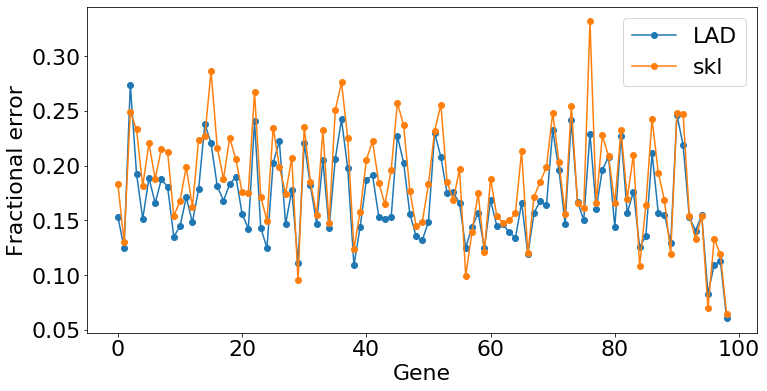

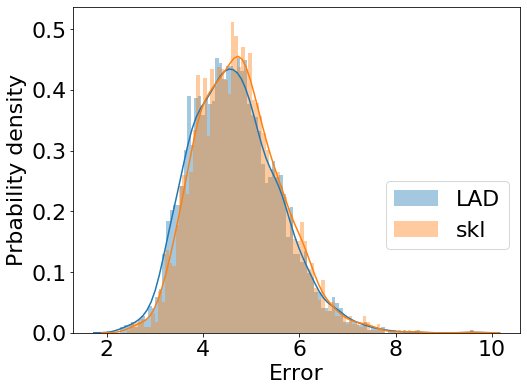

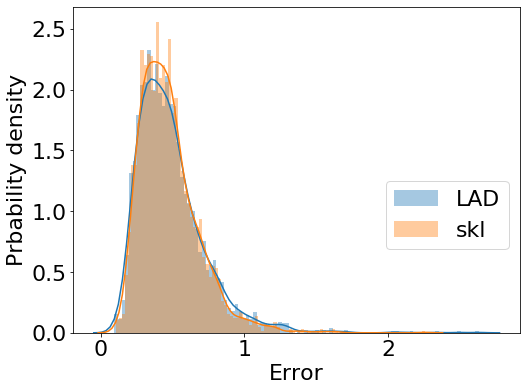

In [13]:
import seaborn as sns

matplotlib.rcParams.update({'font.size':22})
plt.figure(figsize=(12,6))
plt.plot(range(len(LAD_quad_v[0]['ferror'])), LAD_quad_v[0]['ferror'], 'o-', label='LAD')
plt.plot(range(len(skl_quad_v[0]['ferror'])), skl_quad_v[0]['ferror'], 'o-', label='skl')
plt.xlabel('Gene')
plt.ylabel('Fractional error')
plt.legend(loc='best')

plt.figure(figsize=(8,6))
error_lad = np.sum(LAD_quad_v[0]['error'], axis=1)
sns.distplot(error_lad, bins=100, label='LAD')
error_skl = np.sum(skl_quad_v[0]['error'], axis=1)
sns.distplot(error_skl, bins=100, label='skl')
plt.legend(bbox_to_anchor=(1,0.5))
plt.xlabel('Error')
plt.ylabel('Prbability density')

print(stats.mannwhitneyu(error_lad, error_skl))

plt.figure(figsize=(8,6))
error_lad = np.sum(LAD_quad_v[0]['error']**2, axis=1)
sns.distplot(error_lad, bins=100, label='LAD')
error_skl = np.sum(skl_quad_v[0]['error']**2, axis=1)
sns.distplot(error_skl, bins=100, label='skl')
plt.legend(bbox_to_anchor=(1,0.5))
plt.xlabel('Error')
plt.ylabel('Prbability density')

print(stats.mannwhitneyu(error_lad, error_skl))

### (99,27) to 27

In [14]:
# plt.figure(figsize=(12,6))
# plt.plot(range(len(LAD_quad_v[1]['ferror'])), LAD_quad_v[1]['ferror'], 'o-', label='LAD')
# plt.plot(range(len(skl_quad_v[1]['ferror'])), skl_quad_v[1]['ferror'], 'o-', label='skl')
# plt.xlabel('Gene')
# plt.ylabel('Fractional error')
# plt.legend(loc='best')

# plt.figure(figsize=(8,6))
# error_lad = np.sum(LAD_quad_v[1]['error'], axis=1)
# sns.distplot(error_lad, bins=100, label='LAD')
# error_skl = np.sum(skl_quad_v[1]['error'], axis=1)
# sns.distplot(error_skl, bins=100, label='skl')
# plt.legend(bbox_to_anchor=(1,0.5))
# plt.xlabel('Error')
# plt.ylabel('Prbability density')

# print(stats.mannwhitneyu(error_lad, error_skl))

# plt.figure(figsize=(8,6))
# error_lad = np.sum(LAD_quad_v[1]['error']**2, axis=1)
# sns.distplot(error_lad, bins=100, label='LAD')
# error_skl = np.sum(skl_quad_v[1]['error']**2, axis=1)
# sns.distplot(error_skl, bins=100, label='skl')
# plt.legend(bbox_to_anchor=(1,0.5))
# plt.xlabel('Error')
# plt.ylabel('Prbability density')

# print(stats.mannwhitneyu(error_lad, error_skl))

### (27,27) to 27

In [15]:
# plt.figure(figsize=(12,6))
# plt.plot(range(len(LAD_quad_v[2]['ferror'])), LAD_quad_v[2]['ferror'], 'o-', label='LAD')
# plt.plot(range(len(skl_quad_v[2]['ferror'])), skl_quad_v[2]['ferror'], 'o-', label='skl')
# plt.xlabel('Gene')
# plt.ylabel('Fractional error')
# plt.legend(loc='best')

# plt.figure(figsize=(8,6))
# error_lad = np.sum(LAD_quad_v[2]['error'], axis=1)
# sns.distplot(error_lad, bins=100, label='LAD')
# error_skl = np.sum(skl_quad_v[2]['error'], axis=1)
# sns.distplot(error_skl, bins=100, label='skl')
# plt.legend(bbox_to_anchor=(1,0.5))
# plt.xlabel('Error')
# plt.ylabel('Prbability density')

# print(stats.mannwhitneyu(error_lad, error_skl))

# plt.figure(figsize=(8,6))
# error_lad = np.sum(LAD_quad_v[2]['error']**2, axis=1)
# sns.distplot(error_lad, bins=100, label='LAD')
# error_skl = np.sum(skl_quad_v[2]['error']**2, axis=1)
# sns.distplot(error_skl, bins=100, label='skl')
# plt.legend(bbox_to_anchor=(1,0.5))
# plt.xlabel('Error')
# plt.ylabel('Prbability density')

# print(stats.mannwhitneyu(error_lad, error_skl))

# train/validation 10 fold skl vs. train/validation skl - sanity check

MannwhitneyuResult(statistic=4618569.0, pvalue=0.48699935373194159)
MannwhitneyuResult(statistic=4619361.0, pvalue=0.49161472156088182)


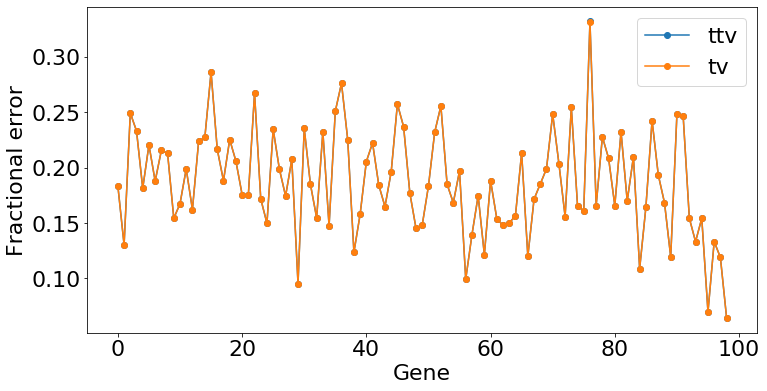

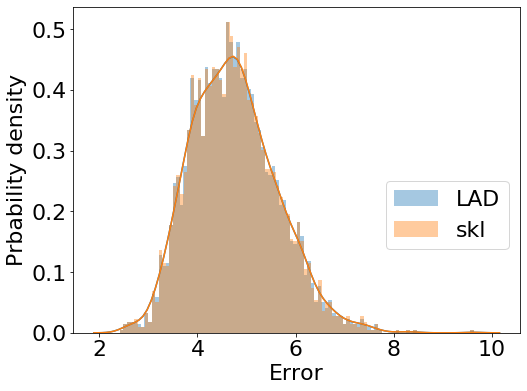

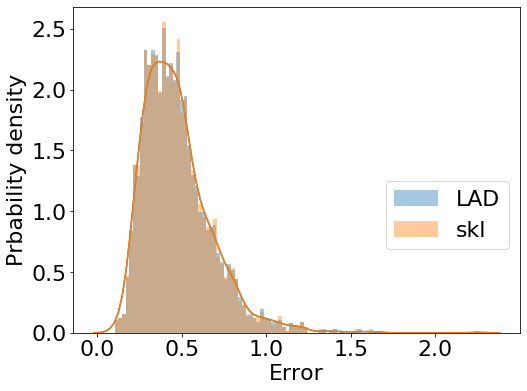

In [16]:
with open('./pickles/skl_quad_ttv.pkl', 'rb') as f:
    skl_quad_ttv = pickle.load(f)
    
with open('./pickles/skl_quad_tv.pkl', 'rb') as f:
    skl_quad_tv = pickle.load(f)
    
import seaborn as sns

matplotlib.rcParams.update({'font.size':22})
for i in range(1):
    plt.figure(figsize=(12,6))
    plt.plot(range(len(skl_quad_ttv[i]['ferror'])), skl_quad_ttv[i]['ferror'], 'o-', label='ttv')
    plt.plot(range(len(skl_quad_tv[i]['ferror'])), skl_quad_tv[i]['ferror'], 'o-', label='tv')
    plt.xlabel('Gene')
    plt.ylabel('Fractional error')
    plt.legend(loc='best')
    
    plt.figure(figsize=(8,6))
    error_lad = np.sum(skl_quad_ttv[i]['error'], axis=1)
    sns.distplot(error_lad, bins=100, label='LAD')
    error_skl = np.sum(skl_quad_tv[i]['error'], axis=1)
    sns.distplot(error_skl, bins=100, label='skl')
    plt.legend(bbox_to_anchor=(1,0.5))
    plt.xlabel('Error')
    plt.ylabel('Prbability density')
    
    print(stats.mannwhitneyu(error_lad, error_skl))
    
    plt.figure(figsize=(8,6))
    error_lad = np.sum(skl_quad_ttv[i]['error']**2, axis=1)
    sns.distplot(error_lad, bins=100, label='LAD')
    error_skl = np.sum(skl_quad_tv[i]['error']**2, axis=1)
    sns.distplot(error_skl, bins=100, label='skl')
    plt.legend(bbox_to_anchor=(1,0.5))
    plt.xlabel('Error')
    plt.ylabel('Prbability density')
    
    print(stats.mannwhitneyu(error_lad, error_skl))